## Lab: A logistic regression to classify astronomical objects

In this lab you will learn how to use TensorFlow to create a simple logistic regression model that classifies astronomical objects between two classes: quasi-stellar objects (QSOs) and galaxies, according to their observed properties. These properties are the fluxes (light intensities) measured with a telescope using different filters, and the distance to the object, as measured by the "redshift", $z$. Most of the code here is based on a TensorFlow example by Vihar Kurama. 

### SDSS colors

The Sloan Digital Sky Survey is a project that uses a few telescopes and instruments to measure the brightness and motions of stars and galaxies. It observes objects using different color filters, and those different colors can be used to infer the type of the object, in a similar way as you can tell the temperature of an steel bar by looking at its color when it is being heated. We will code up a logistic regression model that will learn to distinguish between galaxies and QSOs by looking at these colors, as well as the distance to the galaxies (images taken from the astroML and scikit-learn projects).

![sdss_colors](plot_sdss_filters_1.png)
![sdss_colors2](plot_sdss_filters_2.png)


### Loading the dataset
We start by doing the relevan imports first. We will use pandas to manipulate our dataset, which is a list of colors and redshifts measured for many objects in the sky, and tensorflow as our main tool for doing automatic differentiation and building the logistic regression:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2022-06-29 13:31:45.092247: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


The dataset is a table containing one row for each object. The columns are the magnitudes (you can think of magnitudes as an indication of brightness) in the different SDSS "colors" or "filters": $u, g, r, i, z$. In addition to the magnitudes, the redshift ($z1$) is an indication of the distante to the object, and $z_{\rm{err}}$ measures its error. There is also a label, which indicates the class of the object (either QSO or galaxy). These labels will be our target quantities in the classification exercise. Let's load the dataset using pandas. We convert the data type of the numerical values from 64-bit floats to 32-bit float.

In [2]:
data = pd.read_csv('Skyserver_SQL6_13_2022_6_01_53_PM.csv')
float_cols = [c for c in data if data[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}
data = pd.read_csv('Skyserver_SQL6_13_2022_6_01_53_PM.csv', engine='c', dtype=float32_cols)

In [3]:
data

,u,g,r,i,z,label,z1,zerr
0,17.882219,15.960280,15.061700,14.596340,14.262910,GALAXY,0.024328,0.000007
1,18.563690,16.723270,15.796230,15.370910,15.001250,GALAXY,0.070124,0.000012
2,19.294109,17.502300,16.586491,16.163031,15.813410,GALAXY,0.049190,0.000015
3,19.333590,17.437780,16.458441,15.999580,15.668430,GALAXY,0.080963,0.000011
4,18.928631,18.661831,18.277420,18.222160,18.330410,QSO,1.234354,0.000313
...,...,...,...,...,...,...,...,...
49995,19.443760,18.168680,17.611271,17.234631,17.036989,GALAXY,0.081990,0.000009
49996,19.362280,19.319090,19.318140,19.133801,18.812941,QSO,2.115130,0.000132
49997,19.423420,18.056681,17.134609,16.649920,16.467159,GALAXY,0.131247,0.000015
49998,18.588011,17.442011,16.938610,16.577280,16.421881,GALAXY,0.082057,0.000008


There are 50,000 objects in the dataset. However, QSOs are underepresented in the dataset, accounting for just about 16% of the entire dataset. Classe that are underrepresented in a gvie dataset can be difficult to classify, and so we keep only a similar number of galaxies and QSOs, by keeping only a similar number of galaxies. The resulting dataset has about 15,000 objects.

In [4]:
df_galaxies = data.loc[data['label'] == 'GALAXY'][0:8000]
df_qsos = data.loc[data['label'] == 'QSO']

frames = [df_galaxies, df_qsos]

data = pd.concat(frames)

data = data.sample(frac=1)

In [5]:
data

,u,g,r,i,z,label,z1,zerr
6751,17.524879,16.575439,16.139450,15.883020,15.724490,GALAXY,0.034459,0.000008
11671,18.608379,17.884230,17.318760,16.902050,16.701941,QSO,0.125307,0.000028
6783,18.549110,16.720970,15.903510,15.506470,15.239260,GALAXY,0.052114,0.000011
4162,17.165609,15.328740,14.516340,14.089720,13.757170,GALAXY,0.036286,0.000011
13406,18.391251,18.224489,17.957001,17.866940,17.900209,QSO,1.395270,0.000132
...,...,...,...,...,...,...,...,...
27037,19.309349,19.351009,19.128740,19.086599,19.248461,QSO,1.356175,0.000582
966,19.079990,17.408529,16.601191,16.186979,15.927030,GALAXY,0.087510,0.000026
8591,18.955420,17.817039,17.234711,16.873619,16.680149,GALAXY,0.099120,0.000008
40445,18.898140,18.645760,18.614161,18.422970,18.355240,QSO,1.858533,0.000264


### Visualizing the dataset

We now visualize the features that we will use to classify between the two types of objects. The plots below show that the two types are well separated in some of the features, and not in others. In particular, we plot the color-color diagrams $u-g$ vs. $g-r$, $r-i$ vs. $i-z$, as well as these colors compared with the redshift distribution. Note that QSOs tend to have redder colors with respect to galaxies. This is because they caan be hevaily obscured by dust and have less recent star formation, and hence, less young. massive, blue stars. There is, however some overlap between the two types and the decision bondaries are not necessaily linear.

Text(0, 0.5, 'redshift error')

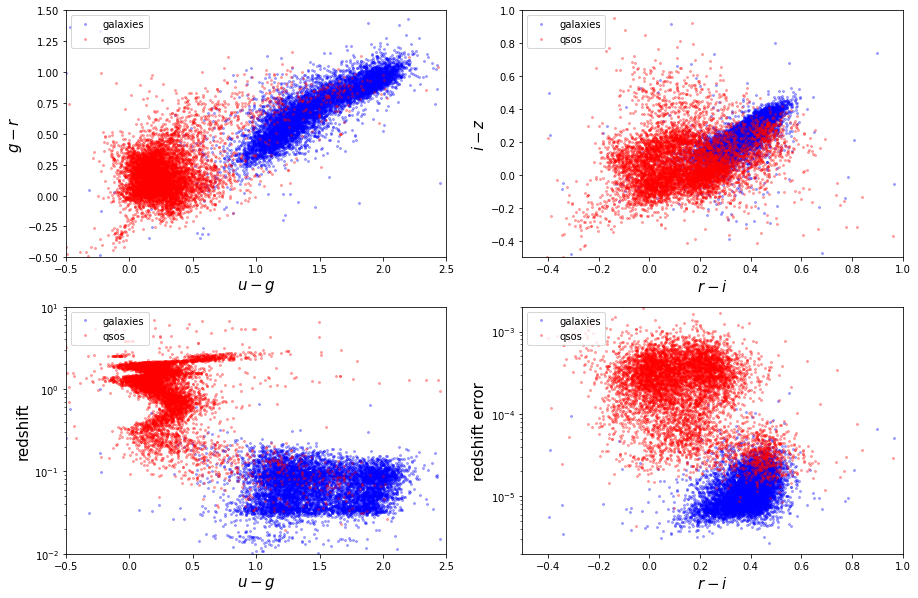

In [6]:
# Extract colors and spectral class
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
spec_class = data['label']

galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')


fig, axs = plt.subplots(2, 2,figsize = (15,10))
axs[0, 0].plot(ug[galaxies], gr[galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[0, 0].plot(ug[qsos], gr[qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[0, 0].set_xlim(-0.5, 2.5)
axs[0, 0].set_ylim(-0.5, 1.5)
axs[0, 0].legend(loc=2)
axs[0, 0].set_xlabel('$u-g$',size=15)
axs[0, 0].set_ylabel('$g-r$',size=15)
axs[0, 1].plot(ri[galaxies], iz[galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[0, 1].plot(ri[qsos], iz[qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[0, 1].set_xlim(-0.5, 1.0)
axs[0, 1].set_ylim(-0.5, 1.0)
axs[0, 1].legend(loc=2)
axs[0, 1].set_xlabel('$r-i$',size=15)
axs[0, 1].set_ylabel('$i-z$',size=15)
axs[1, 0].plot(ug[galaxies], data['z1'][galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[1, 0].plot(ug[qsos], data['z1'][qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlim(-0.5, 2.5)
axs[1, 0].set_ylim(0.01, 10.0)
axs[1, 0].legend(loc=2)
axs[1, 0].set_xlabel('$u-g$',size=15)
axs[1, 0].set_ylabel('redshift',size=15)
axs[1, 1].plot(ri[galaxies], data['zerr'][galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[1, 1].plot(ri[qsos], data['zerr'][qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlim(-0.5, 1.0)
axs[1, 1].set_ylim(0.000002, 0.002)
axs[1, 1].legend(loc=2)
axs[1, 1].set_xlabel('$r-i$',size=15)
axs[1, 1].set_ylabel('redshift error',size=15)

#for ax in axs.flat:
#    ax.set(xlabel='u-g', ylabel='z')

### Splitting the data
We now convert the categorical labels 'Galaxy' and 'QSO' to a numerical binary representation. We also split the dataset into a training set and a test set. The training set will contain about $75%$ of the samples, following standard practices. We also set apart the column that corresponds to the label, which is the target of our prediction.

In [7]:
data['label'] = pd.Categorical(data['label'])
data['label'] = data.label.cat.codes
data.head()

,u,g,r,i,z,label,z1,zerr
6751,17.524879,16.575439,16.139450,15.88302,15.724490,0,0.034459,0.000008
11671,18.608379,17.884230,17.318760,16.90205,16.701941,1,0.125307,0.000028
6783,18.549110,16.720970,15.903510,15.50647,15.239260,0,0.052114,0.000011
4162,17.165609,15.328740,14.516340,14.08972,13.757170,0,0.036286,0.000011
13406,18.391251,18.224489,17.957001,17.86694,17.900209,1,1.395270,0.000132


In [8]:
var_target = data.pop('label')

In [9]:
x_train = data.values[0:11500]
x_test = data.values[11500:]

y_train = var_target.values[0:11500]
y_test = var_target.values[11500:]

### Initializing the model, and randomizing the data
We now initialize our logistic regression model. We specify the number of classes into which we are classifying the input objects, the number of features to be used, as well as the training parameters for the optimization. The lerning rate (size of the jump when doing gradient descent), the number of training steps (each time the model sees the entire training set), and the batch size (how many examples do we use to do the gradient update) are all done here.

We also create the batches and re-shuffle the data. Both of these operations are done to guarantee that the model is not biased by a particular ordering of the data. For example, here we will be taken random batches of 129 objects in order to estimate the direction of the gradient, with mini-batch gradient descent.

In [10]:
#dataset parameters.

num_classes = 2 

num_features = 7

# Training parameters.

learning_rate = 0.00001

training_steps = 1000

batch_size = 128

display_step = 50

In [12]:
# Use tf.data API to shuffle and batch data.

train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))

train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [13]:
train_data

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.int8)>

### Setting up the model

We now define and initialize the weights and the biases for the model. These are the model parameters that will be updated during the optimization in each trainit step. We initialize them as a matrix with dimension $n_{\rm{feat}}\times n_{\rm{class}}$. The bias vector has a dimension equal to the number of output neurons, which equals the number of classes in the *softmax* representation. *Question:* what would be different if we would have used a sigmoid activation instead of a softmax activation? How many bias terms would we need?

In [14]:
# Weight of shape, and a total number of classes.

W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")

# Bias of shape [2], the total number of classes.

b = tf.Variable(tf.zeros([num_classes]), name="bias")

We now define two functions: the softmax (logistic regression) activation function, and the function that calculates the cross-entropy loss function. Cross-entropy is a common loss funnction for classification problems, as it compares the actual label with the probability that the model gives to that label (see lecture). The *One-hot* encoding is a way to pass the categorical classes to the logistic regression in a numerical fashion.

In [15]:
# Logistic regression (Wx + b).

def logistic_regression(x):

    # Apply softmax to normalize the logits to a probability distribution.

    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.

def cross_entropy(y_pred, y_true):

    # Encode label to a one hot vector.

    y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=num_classes)

    # Clip prediction values to avoid log(0) error.

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

Next we define anothr function that will evaluate the accuracy of our prediction. Effectively, it will compare the true labels to the predicted ones and count the number of errors that the algorithm made. We also define an optimizer, that will be the stochastic gradient descent algorithm with the learning rate specified above.

In [16]:
# Accuracy metric.

def accuracy(y_pred, y_true):

# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64)) # Look where the prediction was correct

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  # Estimates the mean over samples

# Stochastic gradient descent optimizer.

optimizer = tf.optimizers.SGD(learning_rate)

We now create a function that runs the optimization. We have discussed the backpropagation algorithm in class. As we have seen, it backpropagates the error in the prediction in order to update the weights of the network by estimating the partial derivatives of the errors with respect to the weights. Because in intermediate layers that partial derivative depends on the outputs of layers further down the network, in the "future", then the algorithm needs to remember the order in which the operations were performed in the forward pass. TensorFlow offers an API (GradientTape) that remembers the order of the operations, making the backpropagation training much easier.

In [17]:
# Optimization process. 

def run_optimization(x, y):

# Wrap computation inside a GradientTape for automatic differentiation.

    with tf.GradientTape() as g:

        pred = logistic_regression(x)
        
        #print('pred = ', pred)

        loss = cross_entropy(pred, y)
        
        #print('loss = ', loss)

    # Compute gradients.

    gradients = g.gradient(loss, [W, b])
    #print('Gradients = ',gradients)
  

    # Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients, [W, b]))

We now perform the training by running the function that we have just defined. We pass the data in batches, which helps in the generalization, as the network is seeing a slightly different training set in each step. We track the loss, as well as the accuracy of our model.

In [18]:
# Run training for the given number of steps.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # Run the optimization to update W and b values.
    
    #print(batch_x,batch_y)

    run_optimization(batch_x, batch_y)

    

    if step % display_step == 0:

        pred = logistic_regression(batch_x)

        loss = cross_entropy(pred, batch_y)

        acc = accuracy(pred, batch_y)

        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

2022-06-29 13:50:10.652986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


step: 50, loss: 83.985489, accuracy: 0.757812
step: 100, loss: 78.551277, accuracy: 0.609375
step: 150, loss: 77.779785, accuracy: 0.921875
step: 200, loss: 72.702263, accuracy: 0.960938
step: 250, loss: 69.269829, accuracy: 0.945312
step: 300, loss: 68.178909, accuracy: 0.914062
step: 350, loss: 61.494682, accuracy: 0.960938
step: 400, loss: 63.812386, accuracy: 0.914062
step: 450, loss: 59.586929, accuracy: 0.968750
step: 500, loss: 55.560356, accuracy: 0.976562
step: 550, loss: 55.754322, accuracy: 0.968750
step: 600, loss: 58.789864, accuracy: 0.937500
step: 650, loss: 52.485458, accuracy: 0.953125
step: 700, loss: 52.443180, accuracy: 0.953125
step: 750, loss: 52.333942, accuracy: 0.937500
step: 800, loss: 47.698792, accuracy: 0.953125
step: 850, loss: 48.256046, accuracy: 0.960938
step: 900, loss: 48.139053, accuracy: 0.968750
step: 950, loss: 45.300316, accuracy: 0.945312
step: 1000, loss: 45.152924, accuracy: 0.953125


Finally, we print the accuracy of the model after taining. The latter is obtained by comparing the model predictions in the test set with the actual true labels.

In [19]:
# Test model on validation set.

pred = logistic_regression(x_test)

print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.954154


In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty='none').fit(x_train, y_train)
clf.coef_

/home/alejoman/miniconda3/envs/MastMLEnv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[-6.68922853,  9.7576178 ,  0.27683421, -2.98448958, -1.65079069,
        17.66581793, -0.19799817]])